<a href="https://colab.research.google.com/github/MohamedAteya/BERT-Fine-Tuning-Sentence-Classification-for-CoLA/blob/master/BERT_Fine_Tuning_Sentence_Classification_for_CoLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Check for GPUs

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()


# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


## Install transformers Library

In [ ]:
!pip install transformers

# Loading CoLA Dataset

The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect.

In [ ]:
!pip install wget

In [ ]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [ ]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.head()

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# Tokenization & Preprocessing

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode( sent, add_special_tokens = True)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [ ]:
print('Max length: ', max([len(sen) for sen in input_ids]))

Max length:  47


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# I've chosen 64 somewhat arbitrarily. It's slightly larger than the maximum training sentence length of 47...
MAX_LEN = 64

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

# Train and Validation sets split

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=13, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=13, test_size=0.1)

# DataLoader preperation

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Train Classification model (BertForSequenceClassification)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,          
    output_attentions = False, 
    output_hidden_states = False
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Optimizer & Learning Rate Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5,  eps = 1e-8 )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
import random

seed_val = 13

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

         
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        


        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # loss value out of the tuple.
        loss = outputs[0]

        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        

        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  Batch    80  of    241.    Elapsed: 0:00:34.
  Batch   120  of    241.    Elapsed: 0:00:51.
  Batch   160  of    241.    Elapsed: 0:01:07.
  Batch   200  of    241.    Elapsed: 0:01:24.
  Batch   240  of    241.    Elapsed: 0:01:41.

  Average training loss: 0.49
  Training epcoh took: 0:01:41

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  Batch    80  of    241.    Elapsed: 0:00:34.
  Batch   120  of    241.    Elapsed: 0:00:51.
  Batch   160  of    241.    Elapsed: 0:01:08.
  Batch   200  of    241.    Elapsed: 0:01:25.
  Batch   240  of    241.    Elapsed: 0:01:42.

  Average training loss: 0.30
  Training epcoh took: 0:01:42

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:17.
  

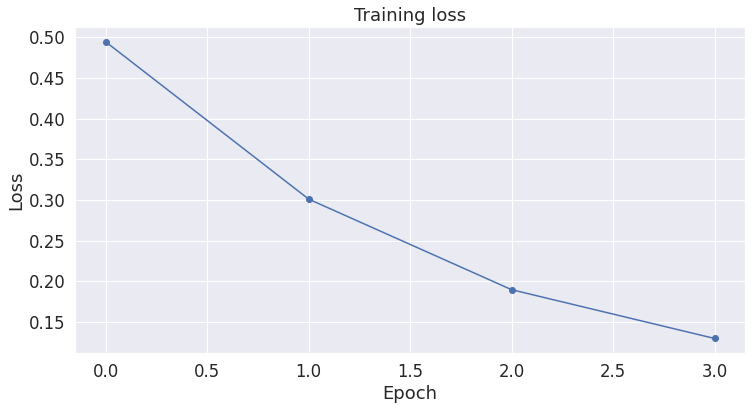

In [44]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show();

# Performance in test Set

Matthew's correlation coefficient is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform this specific task.

## Test data preparation

In [45]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []


for sent in sentences:

    encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [47]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [49]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient


for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [51]:
# scores for individual batches
matthews_set

[-0.14856415213808927,
 -0.2548235957188128,
 0.4040950971038548,
 0.34151450937027694,
 0.32328707534629597,
 0.7410010097502685,
 0.5555555555555556,
 0.0,
 0.8320502943378436,
 0.7704873741021288,
 0.7679476477883045,
 0.5465943944999485,
 0.7562449037944323,
 0.7125253031944253,
 0.2342878320018382,
 0.49382916465843113,
 0.0]

In [52]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.492


# Saving the model

In [53]:
import os

output_dir = './model_save/'


if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')